<a href="https://colab.research.google.com/github/xinnazim/esaa/blob/main/%ED%95%B8%EC%A6%88%EC%98%A8_4%EC%9E%A5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **CH04. 모델 훈련 157~202p**
- 선형 회귀 모델 훈련 방법
  + 직접 계산할 수 있는 공식을 사용해 훈련 세트에 가장 잘맞는 모델 파라미터를 구함
  + 경사 하강법(반복적인 최적화 방식)을 사용해 모델 파라미터를 조금씩 바꾸면서 비용 함수를 훈련 세트에 대해 최적화 시킴

- 다항 회귀 모델 훈련 방법
  + 선형회귀보다 파라미터가 많아 훈련 데이터에 과대적합되기 쉬움
  + 학습 곡선을 사용해 과대적합을 감지
  + 규제 기법

- 분류 모델 훈련 방법
  + 로지스틱 회귀
  + 소프트맥스 회귀


----------------------------
### 4.1 선형회귀
- 일반적 선형 모델
  + 입력 특성의 가중치 합과 편향이라는 상수를 더해 예측을 만듦
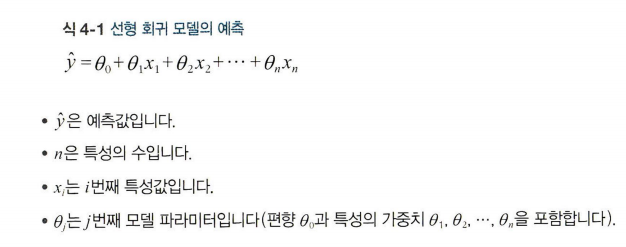

+ 벡터 형태로 더 간단하게 쓸 수 있음

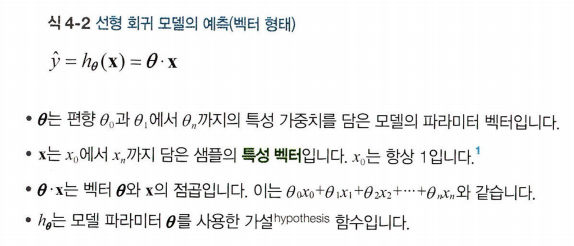

- 선형 회귀 모델 훈련
 + 먼저 모델이 훈련 데이터에 잘 들어맞는지 측정
    + 측정 지표: RMSE (를 최소화하는 세타를 찾아야함)
    + 실제로는 MSE를 최소화하는 것이 더 간단  

#### 4.1.1 정규방정식
- 비용 함수를 최소화하는 $\theta$값을 찾기 위한 해석적인 방법: **정규방정식**
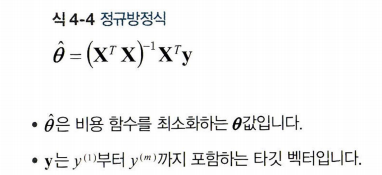

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

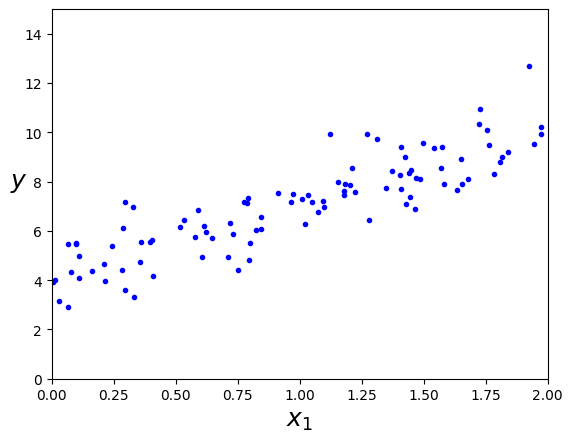

In [ ]:
# 공식 테스트를 위해 선형처럼 보이는 데이터 생성

x = 2*np.random.rand(100,1)
y = 4 + 3*x + np.random.randn(100,1)

# 시각화
plt.plot(x, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([0, 2, 0, 15])

plt.show()

- 넘파이 선형대수 모듈 **np.linalg**에 있는 **inv()** 함수 사용해 역행렬 계산
- **dot()**메서드로 행렬 곱셈

In [ ]:
x_b = np.c_[np.ones((100, 1)), x] #모든 샘플에 x0=1 추가
theta_best = np.linalg.inv(x_b.T.dot(x_b)).dot(x_b.T).dot(y)

> 이 데이터 생성을 위해 사용한 함수 $y=4+3x_1+가우시안 잡음$

In [ ]:
theta_best

array([[4.10607113],
       [2.98915404]])

> 기대한 값과 비슷하지만 잡음으로 인해 기존 함수의 파라미터를 정확하게 재현X

In [ ]:
x_new = np.array([[0], [2]])
x_new_b = np.c_[np.ones((2, 1)), x_new]
y_predict = x_new_b.dot(theta_best)
y_predict

array([[ 4.10607113],
       [10.08437922]])

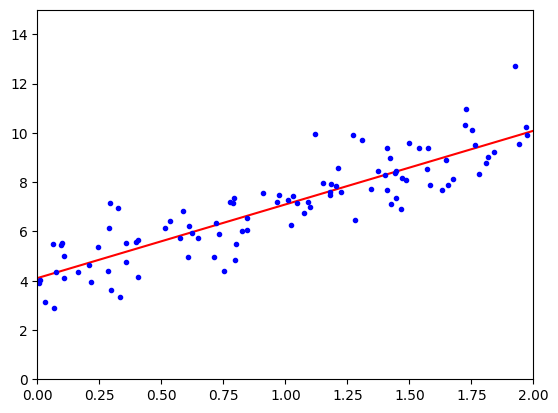

In [ ]:
plt.plot(x_new, y_predict, "r-")
plt.plot(x, y, "b. ")
plt.axis([0, 2, 0, 15])
plt.show()

+ 사이킷런에서 선형 회귀 수행

In [ ]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(x, y)
lin_reg.intercept_, lin_reg.coef_

(array([4.10607113]), array([[2.98915404]]))

In [ ]:
lin_reg.predict(x_new)

array([[ 4.10607113],
       [10.08437922]])

+ scipy.linalg.lstsq() 함수: $\hat{\theta} = X^+ y$을 계산($X^+$ :  $X$의 유사역행렬)

In [ ]:
theta_best_svd, residuals, rank, s = np.linalg.lstsq(x_b, y, rcond=1e-6)
theta_best_svd

array([[4.10607113],
       [2.98915404]])


- np.linalg.pinv() 함수를 사용해 유사역행렬 직접 계산 가능

In [ ]:
np.linalg.pinv(x_b).dot(y)

array([[4.10607113],
       [2.98915404]])

> 유사역행렬은 특잇값 분해(SVD)라 불리는 표준 행렬 분해 기법을 사용해 계산됨

#### 4.1.2 계산 복잡도
- 정규 방정식은 (n+1) X (n+1) 크기가 되는 $X^TX$의 역행렬 계산
  + 역행렬을 계산하는 계산 복잡도는 일반적으로 $O(n^{2.4})$에서 $O(n^{3})$ 사이

- 사이킷런의 LinearRegression 클래스가 사용하는 SVD 방법은 약 $O(n^{2})$

- 학습된 선형 회귀 모델은 예측이 매우 빠름
- 예측 계산 복잡도는 샘플 수와 특성 수에 선형적


### 4.2 경사 하강법
- 경사 하강법(GD): 여러 종류의 문제에서 최적의 해법을 찾을 수 있는 일반적인 최적화 알고리즘
  + 비용 함수를 최소화하기 위해 반복해서 파라미터를 조정

  + $\theta$를 임의의 값으로 시작(무작위 초기화)해서 조금씩 비용 함수가 감소되는 방향으로 진행, 알고리즘이 최솟값에 수렴할 때까지 점진적으로 향상
  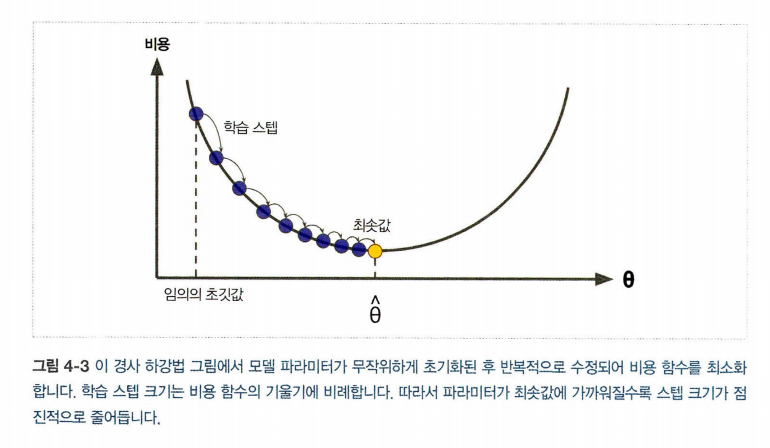
  + 중요한 파라미터는 스텝의 크기로, 학습률 하이퍼파라미터로 결정
    + 학습률이 너무 작으면 반복이 많이 진행되어 시간이 오래 걸림
    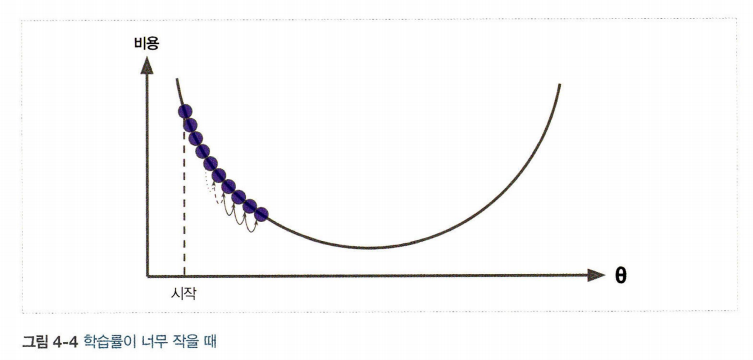
    + 학습률이 너무 크면 최솟값을 건너뛰어 더 큰 값을 가짐
    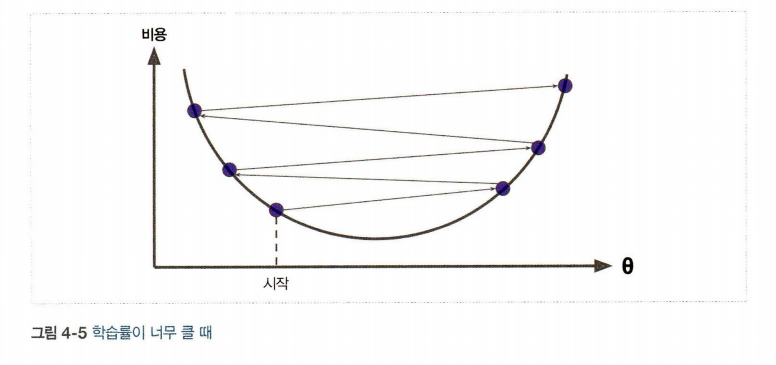




- 경사 하강법의 문제점
  + 무작위 초기화로 인해 알고리즘이 왼쪽에서 시작하면 **전역 최솟값**보다 덜 좋은 **지역 최솟값*에 수렴
  + 오른쪽에서 시작하면 평탄한 지역을 지나기위해 시간이 오래걸리고 일찍 멈춰 전연 최솟값 도달 X
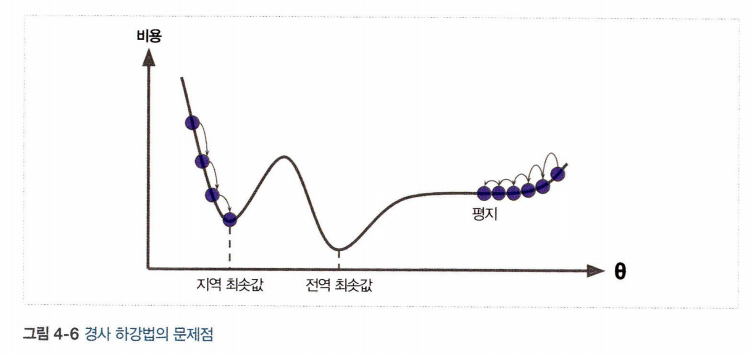

- MSE 비용 함수는 볼록함수
  + 지역 최솟값이 없고 하나의 전역 최솟값만 존재
  + 연속 함수이고 기울기가 갑자기 변하지 않음
  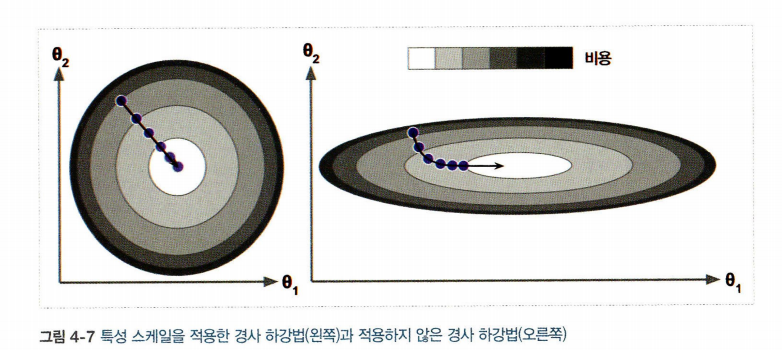



> + 왼쪽: 경사 하강법 알고리즘이 최솟값으로 곧장 진행, 빠르게 도달
+ 오른쪽: 처음엔 직각이다가 길게 돌아서 나감



> 경사 하강법 사용 시 반드시 모든 특성이 같은 스케일을 갖도록 해야함

#### 4.2.1 배치 경사 하강법
- 편도함수

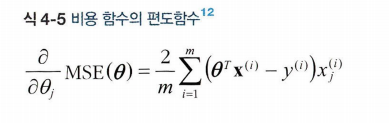
+ 편도함수를 각각 계산하는 대신 한번에 계산 가능

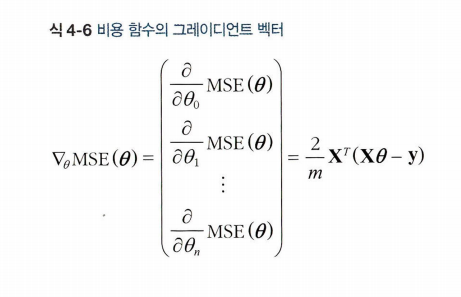


+ 경사 하강법의 스텝

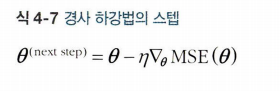


In [ ]:
eta = 0.1  # 학습률
n_iterations = 1000
m = 100

theta = np.random.randn(2,1)  # 무작위 초기화

for iteration in range(n_iterations):
    gradients = 2/m * x_b.T.dot(x_b.dot(theta) - y)
    theta = theta - eta * gradients

In [ ]:
theta

array([[4.10607113],
       [2.98915404]])

> 정규방정식으로 찾은 것과 같음

* 학습률 n을 바꿔보자
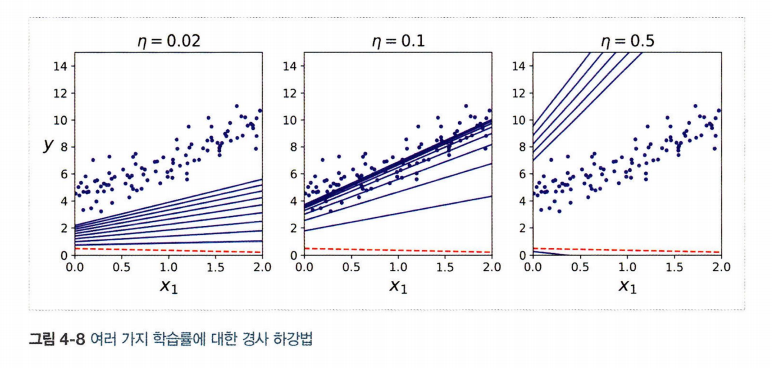



> 가운데가 적당함, 그리드 탐색 사용


#### 4.2.2 확률적 경사 하강법

- 매 스텝에서 한 개의 샘플을 무작위 선택, 그 샘플에 대한 그레이디언트를 계산
- 확률적이라 배치 경사 하강법보다 불안정
- 학습률을 점진적으로 감소시켜서 해결-> 담금질 기법
- 학습 스케줄: 매 반복에서 학습률을 결정하는 함수

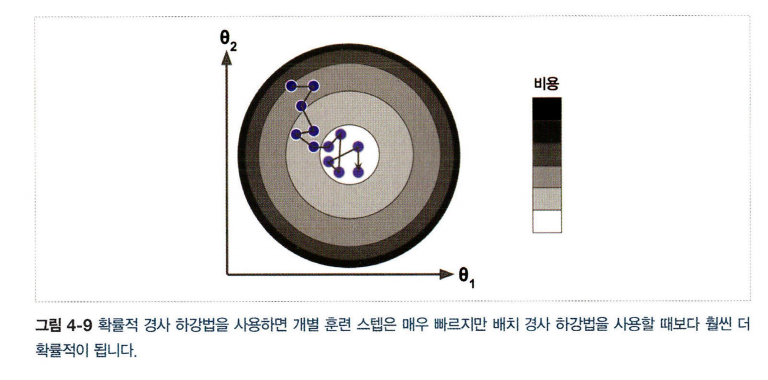

간단한 학습 스케줄 사용한 확률적 경사 하강법의 구현

In [ ]:
n_epochs = 50
t0, t1 = 5, 50  # 학습 스케줄 하이퍼파라미터

def learning_schedule(t):
    return t0 / (t + t1)

theta = np.random.randn(2,1)  # 무작위 초기화

for epoch in range(n_epochs):
    for i in range(m):
        random_index = np.random.randint(m)
        xi = x_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients

> - 일반적으로 한 반복에서 m번 되풀이, 이때 각 반복 = **에포크**
- 1000번 반복하는 동안 이 코드는 50번만 반복하고도 좋은 값 도달

In [ ]:
theta

array([[4.0776321 ],
       [3.01042411]])

* 훈련 스텝의 첫 20개

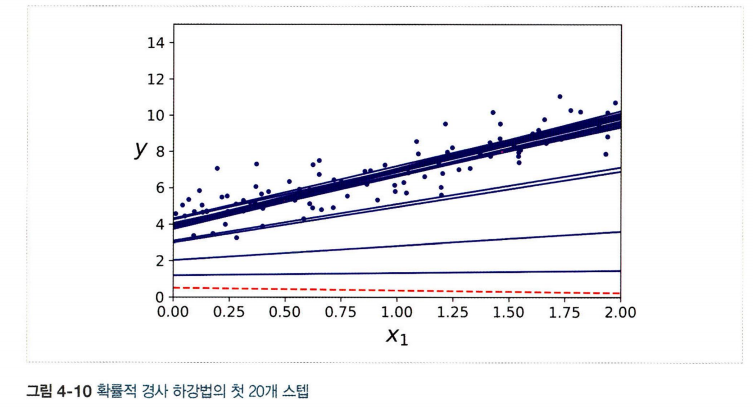

- 샘플을 무작위로 선택하기 때문에 샘플은 한 에포크에서 여러 번 선택될 수 있고 전혀 선택되지 못할 수도 있음
  + 모든 샘플을 사용하게 하기 위해 훈련 세트를 섞은 후(입력 특성, 레이블 동일하게) 차례대로 하나씩 선택 후 다음 에포크에서 다시 섞는 방법 사용(수렴에 걸리는 시간은 더 늘어남)

- 사이킷런에서 SGD 방식으로 선형 회귀를 사용하려면 기본값으로 제곱 오차 비용 함수를 최적화하는 SGDRegressor 클래스 사용

In [15]:
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.1, random_state=42)
sgd_reg.fit(x, y.ravel())

SGDRegressor(eta0=0.1, penalty=None, random_state=42)

In [16]:
sgd_reg.intercept_, sgd_reg.coef_

(array([4.07935065]), array([2.99939524]))

#### 4.2.3 미니배치 경사 하강법
- 미니배치라 부르는 임의의 작은 샘플 세트에 대해 그레이디언트 계산
  + 행렬 연산에 최적화된 하드웨어(GPU)를 사용해 얻는 성능 향상
- SGD보다 최솟값에 더 가까이 도달하지만 지역 최솟값에서 빠져나오기 힘듦

> 선형 회귀를 사용한 알고리즘 비교

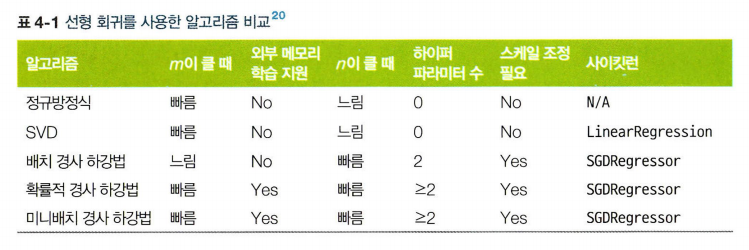

-------------------------
### 4.3 다항 회귀
- 비선형 데이터를 학습하는 선형 모델 훈련

In [17]:
#이차방정식
m = 100
x = 6 * np.random.rand(m, 1) - 3
y = 0.5 * x**2 + x + 2 + np.random.randn(m, 1)

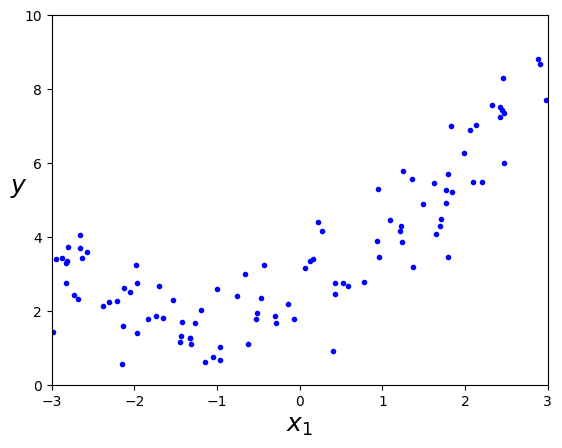

In [18]:
# 그림 4-12
plt.plot(x, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
plt.show()

* 사이킷런의 PolynomialFeatures를 사용해 훈련 데이터 변환

In [19]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)
x_poly = poly_features.fit_transform(x)
x[0]

array([-0.6565688])

In [20]:
x_poly[0]

array([-0.6565688 ,  0.43108258])

> x_poly는 원래 특성과 특성의 제곱을 포함

In [21]:
lin_reg = LinearRegression()
lin_reg.fit(x_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([2.34469111]), array([[0.97534728, 0.42997059]]))

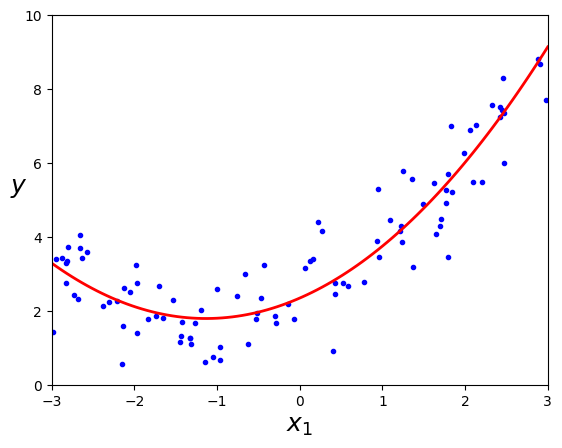

In [22]:
#그림 4-13
x_new=np.linspace(-3, 3, 100).reshape(100, 1)
x_new_poly = poly_features.transform(x_new)
y_new = lin_reg.predict(x_new_poly)

plt.plot(x, y, "b.")
plt.plot(x_new, y_new, "r-", linewidth=2)

plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])

plt.show()

### 4.4 학습 곡선

In [29]:
# 학습 곡선 그리는 함수
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
  X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
  train_errors, val_errors = [], []
  for m in range(1, len(X_train)):
    model.fit(X_train[:m], y_train[:m])
    y_train_predict = model.predict(X_train[:m])
    y_val_predict = model.predict(X_val)
    train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
    val_errors.append(mean_squared_error(y_val, y_val_predict))

  plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="training set")
  plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="validation set")
  plt.ylim([0, 3.0])
  plt.xlabel('Train Set Size')
  plt.ylabel('RMSE')
  plt.legend()

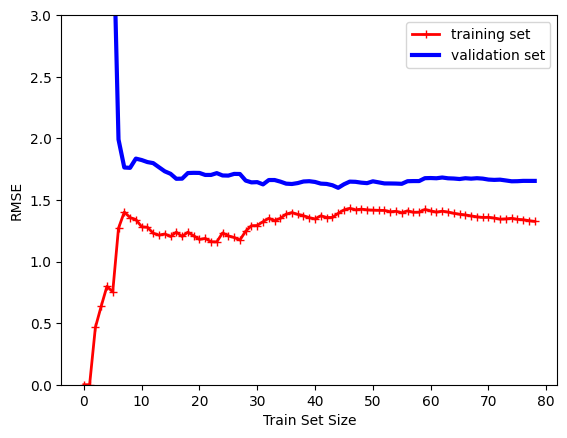

In [30]:
# 단순 선형 회귀 모델의 학습 곡선
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, x, y)

> - 과소적합 모델
    + 곡선이 어느 정도 평편해질 때까지 오차가 계속 상승
    + 훈련 세트에 샘플이 추가되어도 평균 오차가 크게 나아지거나 나빠지지 않음

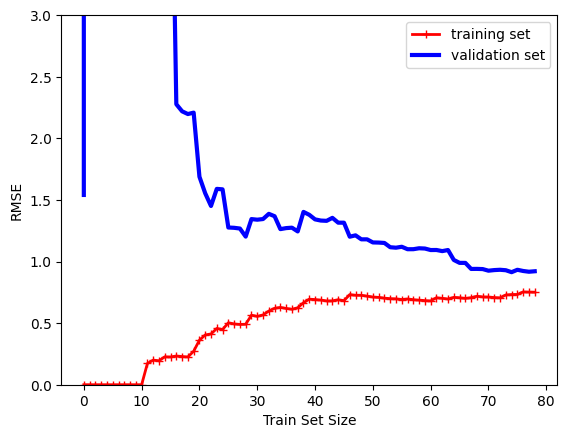

In [31]:
# 같은 데이터에서 10차 다항 회귀 모델의 학습 곡선

from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline([
        ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
        ("lin_reg", LinearRegression()),
    ])

plot_learning_curves(polynomial_regression, x, y)


> - 훈련 데이터의 오차가 선형 회귀 모델보다 훨씬 낮음
- 곡선 사이에 공간이 있음
  + 훈련 데이터에서의 모델 성능이 검증 데이터보다 훨씬 나음->과대적합 모델 특징

### 4.5 규제가 있는 선형 모델
- 다항 회귀 모델을 규제하는 간단한 방법: 다항식의 차수 감소

#### 4.5.1 릿지 회귀
- 규제가 추가된 선형 회귀 버전
  + 규제항이 비용함수에 추가
  + 모델의 가중치가 가능한 한 작게 유지

In [32]:
# 사이킷런에서 정규방정식을 사용한 릿지 회귀를 적용하는 예

from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=1, solver="cholesky")
ridge_reg.fit(x, y)
ridge_reg.predict([[1.5]])

array([[5.07411858]])

In [33]:
# 확률적 경사 하강법 사용
sgd_reg = SGDRegressor(penalty="l2")
sgd_reg.fit(x, y.ravel())
sgd_reg.predict([[1.5]])

array([5.05823504])

> - penalty 매개변수는 사용할 규제 지정
    + l2 = 릿지회귀


#### 4.5.2 라쏘 회귀
- 선형 회귀의 또 다른 규제 버전
- 가중치 벡터의 l1 노름을 사용
- 덜 중요한 특성의 가중치를 제거하려고 함
- 자동으로 특성 선택, 희소 모델 생성

In [34]:
#사이킷런 라쏘 클래스 사용
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(x, y)
lasso_reg.predict([[1.5]])

array([5.02866256])

> Lasso 대신 SGDRegressor(penalty="l1") 사용 가능

#### 4.5.3 엘라스틱넷
- 릿지, 라쏘 절충 모델
- 규제항은 릿지와 회귀의 규제항을 더함
- 혼합 정도는 혼합 비율 r을 사용해 조절
  + r=0 **릿지**
  + r=1 **라쏘**

- 규제가 약간 있는 것이 대부분의 경우에 좋으므로 일반적으로 **평범한 선형 회귀**는 피해야함
  + **릿지**가 기본, 특성이 몇 개뿐이라고 의심되면 **라쏘**나 **엘라스틱넷** 사용
  + 릿지나 엘라스틱넷은 불필요한 특성의 가중치를 0으로 만듦
  + 특성 수가 훈련 샘플 수보다 많거나 특성 몇 개가 강하게 연관되어 있을 떄는 보통 **엘라스틱넷** 선호

In [35]:
# 사이킷런의 엘라스틱넷
from sklearn.linear_model import ElasticNet
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5) #r=0.5
elastic_net.fit(x, y)
elastic_net.predict([[1.5]])

array([5.03212677])

#### 4.5.4 조기 종료
- 경사 하강법과 같은 반복적인 학습 알고리즘을 규제하는 다른 방식: 검증 에러가 최솟값에 도달하면 바로 훈련을 중지 시키는 것
  + 에러가 최소에 도달하는 즉시 훈련을 멈춤

In [37]:
# 조기 종료를 위한 기본적인 구현 코드

from sklearn.base import clone
from sklearn.preprocessing import StandardScaler
X_train, X_val, y_train, y_val=train_test_split(x, y, test_size=0.2)

# 데이터 준비
poly_scaler = Pipeline([
    ("poly_features", PolynomialFeatures(degree=90, include_bias = False)),
    ("std_scaler", StandardScaler())
])
X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)

sgd_reg = SGDRegressor(max_iter=1, tol=None, warm_start=True,
                       penalty=None, learning_rate="constant", eta0=0.0005)

minimum_val_error = float("inf")
best_epoch = None
best_model = None

for epoch in range(1000):
  sgd_reg.fit(X_train_poly_scaled, y_train) #훈련 이어서 진행
  y_val_predict = sgd_reg.predict(X_val_poly_scaled)
  val_error = mean_squared_error(y_val, y_val_predict)
  if val_error < minimum_val_error:
    minimum_val_error = val_error
    best_epoch = epoch
    best_model = clone(sgd_reg)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam


- warm_start = True로 지정하면 fit() 메서드가 호출될 때 처음부터 다시 시작하지 않고 이전 모델 파라미터에서 훈련을 이어감

### 4.6 로지스틱 회귀
- 샘플이 특정 클래스에 속할 확률 추정하는데 사용
  + 추정 확률이 50%가 넘어가면 샘플이 해당 클래스에 속한다고 예측(1,양성 클래스)
  + 반대의 경우 속하지 않는다고 예측(0,음성 클래스)
    + 이를 이진 분류기라고 함


#### 4.6.1 확률 추정
- 선형 회귀 모델과 같이 로지스틱 회귀 모델은 입력 특성의 가중치 합을 계산(그 후 편향을 더함)
  + 그러나 바로 결과를 출력하지 않고 결괏값의 로지스틱을 출력

- 시그모이드 함수: 0과 1 사이의 값을 출력
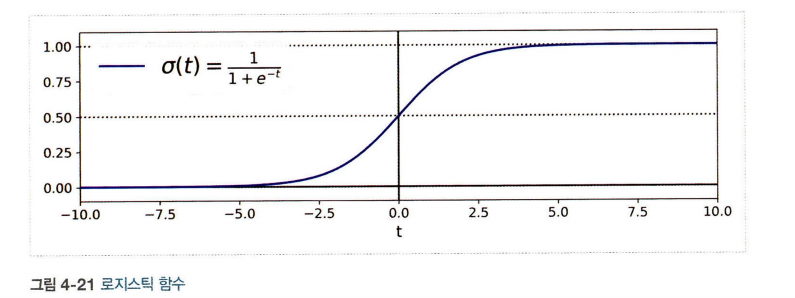



#### 4.6.2 훈련과 비용 함수
- 훈련의 목적: 양성 샘플(y=1)에 대해서는 높은 확률을 추정하고, 음성 샘플(y=0)에 대해서는 낮은 확률을 추정하는 모델의 파라미터 벡터 $\theta$를 찾는 것

- 전체 훈련 세트에 대한 비용 함수: 모든 훈련 샘플의 비용을 평균한 것(=로그 손실)

- 이 비용 함수의 최솟값을 계산하는 알려진 해는 없음


#### 4.6.3 결정 정계
- 로지스틱 회귀를 설명하기 위해 붓꽃 데이터셋 사용
  + 꽃잎 너비를 기반으로 Iris-Versicolor 종을 감지하는 분류기 생성

In [38]:
from sklearn import datasets

iris = datasets.load_iris()
list(iris.keys())

['data',
 'target',
 'frame',
 'target_names',
 'DESCR',
 'feature_names',
 'filename',
 'data_module']

In [39]:
X = iris["data"][:, 3:]  # 꽃잎 너비
y = (iris["target"] == 2).astype(np.int) # Iris-virginica이면 1, 그렇지 않으면 0

<ipython-input-39-035f28acbfa0>:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y = (iris["target"] == 2).astype(np.int) # Iris-virginica이면 1, 그렇지 않으면 0


In [40]:
# 로지스틱 회귀 모델 훈련
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(X, y)

LogisticRegression()

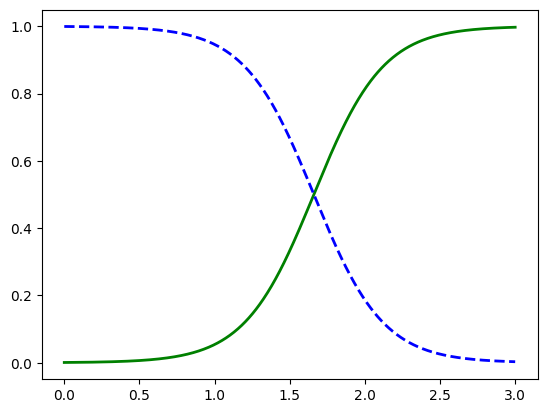

In [41]:
# 꽃잎의 너비 0~3cm 모델 추정 확률 계산
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)

plt.plot(X_new, y_proba[:, 1], "g-", linewidth=2, label="Iris virginica")
plt.plot(X_new, y_proba[:, 0], "b--", linewidth=2, label="Not Iris virginica")

> 중첩되는 부분이 있지만 1.6cm 근방에서 결정 경계 생성

In [42]:
log_reg.predict([[1.7], [1.5]])

array([1, 0])

#### 4.6.3 소프트맥스 회귀
- 다항 로지스틱 회귀라고도 함
- 여러 개의 이진 분류기를 훈련시켜 연결하지 않고 직접 다중 클래스를 지원하도록 일반화된 것

- 샘플 x가 주어지면 먼저 소프트맥스 회귀 모델이 각 클래스 k에 대한 점수 $s_k(x)$를 계산하고, 그 점수에 **소프트맥스 함수**(정규화된 지수 함수)를 적용하여 각 클래스의 확률 추정

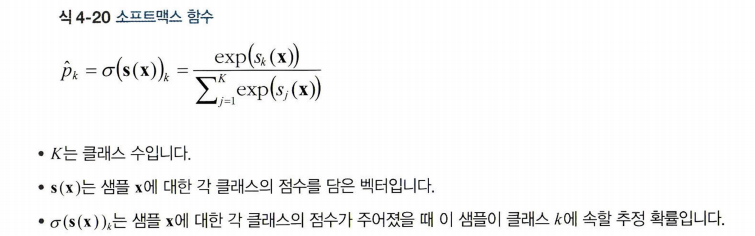

- 로지스틱 회귀 분류기와 마찬가지로 소프트맥스 회귀 분류기는 추정 확률이 가장 높은 클래스를 선택


- 모델이 타깃 클래스에 대해서는 높은 확률을 추정하도록 만드는 것이 목적
  + **크로스 엔트로피** 비용 함수를 최소화하는 것은 타깃 클래스에 대해 낮은 확률을 예측하는 모델을 억제하므로 이 목적에 부합
  + 크로스 엔트로피는 추정된 클래스의 확률이 타깃 클래스에 얼마나 잘 맞는지 측정하는 용도로 종종 사용


In [43]:
# multi_class="multinomial"로 바꾸면 소프트맥스 회귀 사용 가능
# 소프트맥스 사용하려면 solver="lbfgs" 처럼 지원하는 알고리즘 지정

X = iris["data"][:, (2, 3)]  # 꽃잎 길이, 꽃잎 너비
y = iris["target"]

softmax_reg = LogisticRegression(multi_class="multinomial",solver="lbfgs", C=10, random_state=42)
softmax_reg.fit(X, y)

LogisticRegression(C=10, multi_class='multinomial', random_state=42)

In [44]:
softmax_reg.predict([[5,2]])

array([2])

In [45]:
softmax_reg.predict_proba([[5,2]])

array([[6.38014896e-07, 5.74929995e-02, 9.42506362e-01]])

> - 클래스 사이의 결정 경계는 모두 선형
    + (그림 4-25) 모든 결정 경계가 만나는 지점에서는 모든 클래스가 동일하게 33%의 추정 확률을 가짐